# Reading and Plotting Radar Data

### Using PX-1000 Data Collected at Kessler Farm's Field Site

This Jupyter notebook provides Python code to read in the PX-1000 radar data. The PX-1000 data files are netCDF files, which are a type of self-describing file format. Each radar variable is written into a different file. For example, the reflectivity files end with Z.nc and Doppler velocity end with V.nc. 

For plotting, we will make use of <a href='https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html'>matplotlib's pyplot library</a> and use the pcolormesh function to generate color plots of the data.

For more information about the PX-1000 radar, visit the PX-1000 <a href="https://arrc.ou.edu/radar_px1000.html">webpage</a>. You can also view the full archive of data online <a href="https://radarhub.arrc.ou.edu/archive/px1000/">here</a>.

### 11 - 12 May 2023 Tornadoes

On 11 and 12 May 2023, several tornadoes occurred near the Kessler Farm field site. An EF1 tornado occurred between 0129 – 0159 UTC, passing just north of the PX-1000. We'll plot some PX-1000 observations of this tornadic storm. For more information about the tornado outbreak, visit the NWS Norman <a href="https://www.weather.gov/oun/events-20230511">event webpage</a>.

In [1]:
#Import libraries
import datetime
import glob
import numpy as np

import matplotlib.pyplot as plt
import math

from netCDF4 import Dataset

In [2]:
# Set Directory Location and File Name

#Set Data Location
data_dir='/home/jovyan/REU/Data/'

#Type your file name here
fname_Z = 'PX-20230512-013525-E3.0-Z.nc'

In [3]:
#Function to read in the PX-1000 netCDF files
#Z.nc: Reflectivity
#V.nc: Velocity
#D.nc: Differential Reflectivity
#R.nc: Correlation Coefficient

def read_PX1000(fname,dirname):
    #Get the other file names based on the reflectivity file
    fname_V = fname[:-4:]+'V.nc'
    fname_D = fname[:-4:]+'D.nc'
    fname_R = fname[:-4:]+'R.nc'

    #Read in data from the Reflectivity File
    with Dataset(dirname + fname, mode='r') as nc:
        name = nc.getncattr('TypeName')
        elev = np.array(nc.variables['Elevation'][:], dtype=np.float32)
        azim = np.array(nc.variables['Azimuth'][:], dtype=np.float32)
        gatewidth = np.array(nc.variables['GateWidth'][:], dtype=np.float32)
        Z = np.array(nc.variables[name][:], dtype=np.float32)
        Z[Z < -90] = np.nan
        sweepElev = nc.getncattr('Elevation')
        sweepTime = nc.getncattr('Time')

    #Read in Velocity File
    with Dataset(dirname + fname_V, mode='r') as nc:
        name = nc.getncattr('TypeName')
        vr = np.array(nc.variables[name][:], dtype=np.float32)
        vr[vr < -90] = np.nan

    #Read in Differential Reflectivity File
    with Dataset(dirname + fname_D, mode='r') as nc:
        name = nc.getncattr('TypeName')
        ZDR = np.array(nc.variables[name][:], dtype=np.float32)
        ZDR[ZDR < -90] = np.nan

    #Read in Correlation Coefficient File
    with Dataset(dirname + fname_R, mode='r') as nc:
        name = nc.getncattr('TypeName')
        RHOHV = np.array(nc.variables[name][:], dtype=np.float32)
        RHOHV[RHOHV < -90] = np.nan

    #Convert polar coordinate data to km and radians
    r = 1.0e-3 * np.arange(Z.shape[1]) * gatewidth[0]
    a = np.deg2rad(azim)
    e = np.deg2rad(elev)
    #Extract time information
    t = datetime.datetime.utcfromtimestamp(sweepTime)
    timestr = t.strftime('%Y/%m/%d %H:%M:%S')
    timefilestr = t.strftime('%Y%m%d_%H%M%S')

    #Grid data to polor coordinates
    r = r[:,np.newaxis]
    a = a[:,np.newaxis]
    az = np.tile(a,(1,len(r)))
    rr = np.tile(np.transpose(r),(len(a),1))
    xx = np.multiply(rr,np.sin(az))
    yy = np.multiply(rr,np.cos(az))
    
    #Define a dictionary for our output variable: This will be a 
    #collection of radar variables)
    radar_obj = {
        'xx':xx,
        'yy':yy,
        'timestr':timestr,
        'timefilestr':timefilestr,
        'Z':Z,
        'vr':vr,
        'ZDR':ZDR,
        'RHOHV':RHOHV,
        'sweepElev':sweepElev
    }
    return radar_obj
    
    

In [4]:
#Read in the PX-1000 files and extract variables
px1000_obj = read_PX1000(fname_Z,data_dir)

#Extract variables from our Dictionary, px1000_obj, for ease of referencing
Z = px1000_obj['Z']
vr = px1000_obj['vr']
ZDR = px1000_obj['ZDR']
RHOHV = px1000_obj['RHOHV']
xx = px1000_obj['xx']
yy = px1000_obj['yy']
timestr = px1000_obj['timestr']
timefilestr = px1000_obj['timefilestr']

## Make a Plot of Radar Reflectivity Factor

To generate images of radar data, we will use the **pcolormesh()** function. 
**pcolormesh()** generates a 2D color plot from 2D arrays of data. The general structure is:
```python
plt.pcolormesh(X,Y,Z)
```
where Z is the 2D data, and X and Y are optional and are arrays of 1D or 2D data. 
We will create a pcolormesh plot of our radar data using the provided x and y coordinate data,
variables xx and yy, and the following radar variables:
    
- Z: Radar reflectivity factor    
- vr: Doppler velocity
- ZDR: Differential reflectivity
- RHOHV: Correlation coefficient
    
We will add a colormap with a label for the units (meters), use the gist_ncar colormap:
```python
plt.pcolormesh(xx,yy,Z,cmap='gist_ncar')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Radar Reflectivity factor')
```
There are many more colormap options if you wish to try them: <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">Colormaps</a>

We can also set the x-limits and y-limits and add a colorbar:
```python
#Sets the x limits (xmin,xmax)
plt.xlim(-30,30)
#Sets the y limits (ymin,ymax)
plt.ylim(-10,50)
#Creates a colorbar
plt.colorbar()
```

/tmp/ipykernel_229/1850038399.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xx,yy,Z,cmap='gist_ncar')


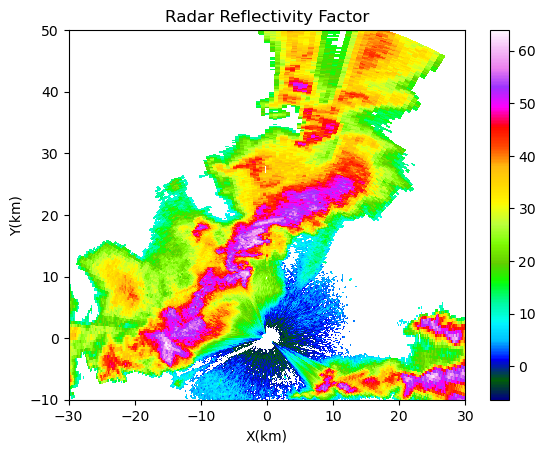

In [5]:
#Use pcolormesh to plot radar reflectivity factor (Z)
plt.figure()
#Creates pcolormesh plot
plt.pcolormesh(xx,yy,Z,cmap='gist_ncar')
#Creates an x-axis label
plt.xlabel('X(km)')
#Creates a y-axis label
plt.ylabel('Y(km)')
#Creates a title
plt.title('Radar Reflectivity Factor')
#Sets the x limits (xmin,xmax)
plt.xlim(-30,30)
#Sets the y limits (ymin,ymax)
plt.ylim(-10,50)
#Creates a colorbar
plt.colorbar()

## Try Yourself! 

Create a plot of Doppler velocity using pcolormesh. Use a different colormap from the options provided in the link above.

## Create a Subplot of Different Radar Variables

On 11 May 2023, PX-1000 scanned a few tornadoes southwest of Oklahoma City, including one just north of Kessler Farm. We'll read in netCDF files from the PX-1000 from this case. The radar works by transmitting a high power radio wave out of an antenna, and a small portion of the wave's energy is reflected by precipitation and other objects (debris, birds, etc.) back to the radar. The radar captures this returned energy and uses it to extract information about precipitation and winds in storms.

As a brief primer, the radar measurements shown will include:
- **Reflectivity (Z)**: This measures the reflected power of precipitation, debris, or other objects. Typically, higher values of reflectivity are associated with larger or more numerous precipitation particles. 
- **Velocity (vr)**: Doppler radars measure the winds toward and away from the radar, with positive values being winds away and negative values being winds toward the radar. Radars can only measure a limited range of wind speeds, so you sometimes see an artifact called aliasing (sudden switch from positive to negative, or vice versa). 
- **Differential Reflectivity (ZDR)**: RaXPol is a dual-polarization radar that measures returns from a horizontally and vertically polarized radio wave. If an object has a larger horizontal cross section, it will usually reflect more power in the horizontal polarization than the vertical polarization. For example, large rain drops have a wider horizontal cross section than a vertical cross section, and thus they have positive ZDR values.
- **Correlation Coefficient (RHOHV)**: The correlation coefficient measures how similar the reflected horizontal and vertical radio waves are. When the radar scans very similar objects or small objects, these tend to produce very similar reflected horizontal and vertical waves. However, if the objects are large and dissimilar (e.g., debris or hail), then lower values are seen. These values range from 0 (uncorrelated) to 1 (perfectly correlated). Values below 0.9 are most likely to be debris or hail.

/tmp/ipykernel_229/1695820237.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm=ax[0,0].pcolormesh(xx,yy,Z,cmap='gist_ncar',vmin=-10,vmax=70)
/tmp/ipykernel_229/1695820237.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm=ax[0,1].pcolormesh(xx,yy,vr,cmap='turbo')
/tmp/ipykernel_229/1695820237.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm=ax[1,0].pcolormes

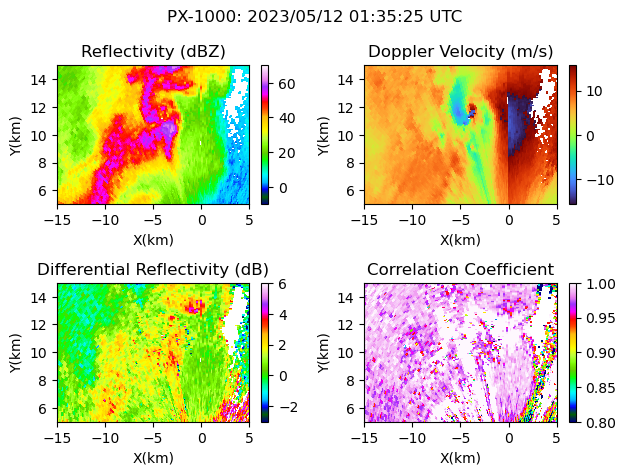

In [9]:
#Create a 2-by-2 plot of the radar variables
#Create a variable to set the x and y limits

#x-limits
xlims = [-15,5]
#y-limits
ylims = [5,15]

#Creates a 2-by-2 subplot
fig,ax = plt.subplots(2,2)

#Sets a title at the top of the figure
fig.suptitle('PX-1000: '+timestr+' UTC')

#Create the first subplot (ax[0,0]) for reflectivity
pcm=ax[0,0].pcolormesh(xx,yy,Z,cmap='gist_ncar',vmin=-10,vmax=70)
ax[0,0].set_xlabel('X(km)')
ax[0,0].set_ylabel('Y(km)')
ax[0,0].set_xlim(xlims)
ax[0,0].set_ylim(ylims)
fig.colorbar(pcm, ax=ax[0,0])
ax[0,0].set_title('Reflectivity (dBZ)')

#Create the second subplot (ax[0,1]) for velocity
pcm=ax[0,1].pcolormesh(xx,yy,vr,cmap='turbo')
ax[0,1].set_xlabel('X(km)')
ax[0,1].set_ylabel('Y(km)')
ax[0,1].set_xlim(xlims)
ax[0,1].set_ylim(ylims)
fig.colorbar(pcm, ax=ax[0,1])
ax[0,1].set_title('Doppler Velocity (m/s)')

#Create the third subplot (ax[1,0]) for differential reflectivity
pcm=ax[1,0].pcolormesh(xx,yy,ZDR,vmin=-3, vmax=6,cmap='gist_ncar')
ax[1,0].set_xlabel('X(km)')
ax[1,0].set_ylabel('Y(km)')
ax[1,0].set_xlim(xlims)
ax[1,0].set_ylim(ylims)
fig.colorbar(pcm, ax=ax[1,0])
ax[1,0].set_title('Differential Reflectivity (dB)')

#Create the second subplot (ax[1,1]) for correlation coefficient
pcm=ax[1,1].pcolormesh(xx,yy,RHOHV,vmin=0.8,vmax=1,cmap='gist_ncar')
ax[1,1].set_xlabel('X(km)')
ax[1,1].set_ylabel('Y(km)')
ax[1,1].set_xlim(xlims)
ax[1,1].set_ylim(ylims)
fig.colorbar(pcm, ax=ax[1,1])
ax[1,1].set_title('Correlation Coefficient')
fig.tight_layout()

plt.savefig('PX1000_' + timefilestr + '.png')

## Try Yourself: Experiment with the Plot

Try changing the x and y limits to look at different zoom levels on the storm.  

## PX-1000 and Mesonet Observation Question

Given the collocation of the PX-1000 and Mesonet site, what type of analysis do you think you could do with observations from both instruments? Think about what types of measurements can radar provide and what can't it provide.  